# Machine Learning and AI

Practical part of the class given by Benoit Gaüzère.

Given that we have different backgrounds, many have not so much experience programming,
I will follow along some more advanced challenges let in the repo by the lecturer.

In [5]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

## Clustering

For this first challenge the idea is to implement my own version of Kmeans algorithm.

### The dataset

The first step is to explore the dataset that I'm going to use.

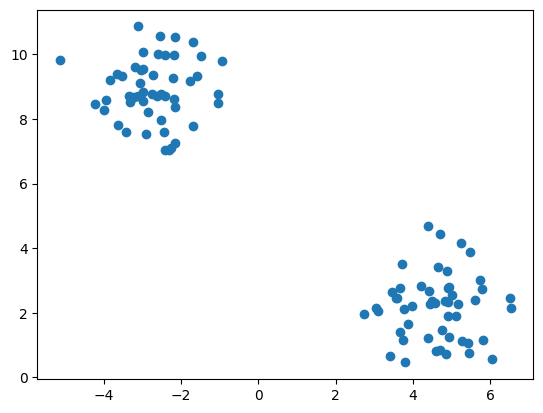

In [6]:
X, y = make_blobs(n_samples=100, centers=2, random_state=42)
plt.scatter(X[:, 0], X[:, 1])
[N,d] = X.shape

### Scikit-learn implementation

First implement the Kmeans clustering using the scikit-learn package.

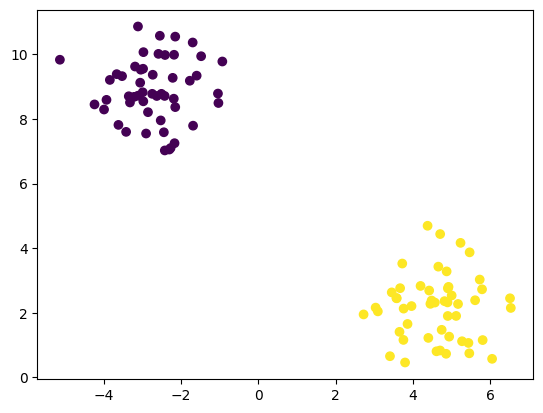

In [7]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=2, n_init='auto')
clustering.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)

### My implementation

The next step is to develop a custom implementation of the kmeans algorithm. In practice
this is not necessary because it is already implemented by the library, however, it is
a great educational exercise to really understand what is happening.

#### Overview of the algorithm.

The Kmeans algorithm is pretty easy to understand. If we want K clusters, you start
with two random points that will act as centers of gravity and classify all points to
the closest gravity center. Afterwards, you calculate the gravity center of each of the
groups by using the classified groups and with this new points repeat the classification.
Iterate through this steps until the gravity centers don't change anymore and you have
your two clusters.

First i'll go implementing a specific algorithm for this dataset and then start to work
out a way to generalize it.


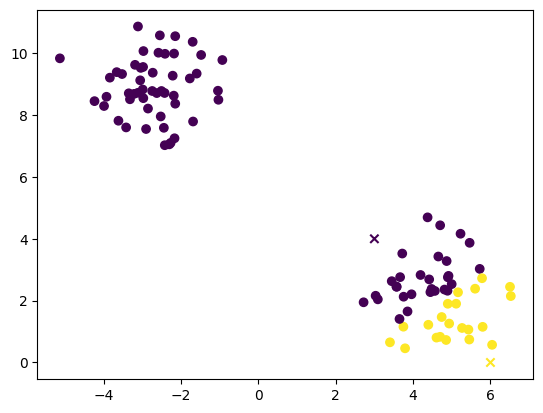

In [8]:
from typing import NamedTuple

class Point(NamedTuple):
    x: float
    y: float

# Initialize 2 centers of gravity randomly
centers = [
    Point(3, 4),
    Point(6, 0)
]

# Distance function
def distance(x: Point, y: Point) -> float:
    """Euclidean distance between two points"""
    return np.sqrt((x.x - y.x)**2 + (x.y - y.y)**2)

# Generator of the dataset as a sequence of points
dataset = [Point(x[0], x[1]) for x in X]

# Function for determining the closest center of gravity
def closest_center(p: Point, centers: list[Point]) -> Point:
    """Return the center of gravity closest to the given point"""
    return min(centers, key=lambda c: distance(p, c))

# Function for classifying a point
def classify(p: Point, centers: list[Point]) -> int:
    """Return the index of the center of gravity closest to the given point"""
    return centers.index(closest_center(p, centers))

labels = [classify(p, centers) for p in dataset]


# Graph the dataset and the centers of gravity
plt.scatter([p.x for p in dataset], [p.y for p in dataset], c=labels)
plt.scatter([c.x for c in centers], [c.y for c in centers], c=[0, 1], marker='x')

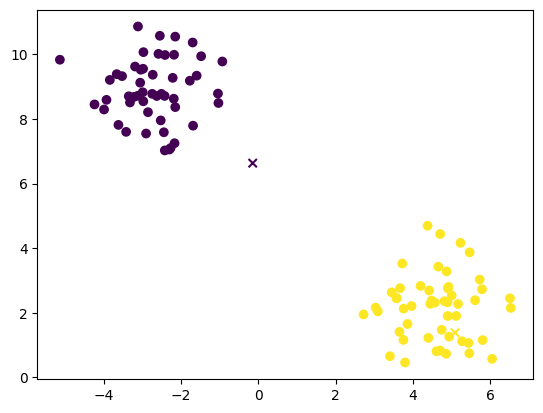

In [9]:
# Function for calculating the center of gravity of a set of points
def center_of_gravity(points: list[Point]) -> Point:
    """Return the center of gravity of the given points"""
    return Point(sum(p.x for p in points) / len(points),
                 sum(p.y for p in points) / len(points))
                
# Update centers of gravity
new_centers = [
    center_of_gravity([p for p, l in zip(dataset, labels) if l == i]) 
    for i in range(len(centers))
]

new_labels = [classify(p, new_centers) for p in dataset]

# Graph the dataset and the centers of gravity
plt.scatter([p.x for p in dataset], [p.y for p in dataset], c=new_labels)
plt.scatter([c.x for c in new_centers], [c.y for c in new_centers], c=[0, 1], marker='x')

Now that I understand the basic algorithm and iteration, let's implement a generic
function that receives the dataset as an iterable of points and then returns the labels.

In [10]:
def k_means(dataset: list[Point], k: int) -> list[Point]:
    """Return k centers of gravity for the given dataset"""
    # Initialize centers of gravity randomly
    centers = [
        Point(
            np.random.uniform(min(p.x for p in dataset), max(p.x for p in dataset)),
            np.random.uniform(min(p.y for p in dataset), max(p.y for p in dataset))
        )
        for _ in range(k)]
    labels = [classify(p, centers) for p in dataset]
    while True:
        # Update centers of gravity
        new_centers = [
            center_of_gravity([p for p, l in zip(dataset, labels) if l == i]) 
            for i in range(len(centers))
        ]
        new_labels = [classify(p, new_centers) for p in dataset]
        if new_labels == labels:
            return new_labels, new_centers
        centers, labels = new_centers, new_labels

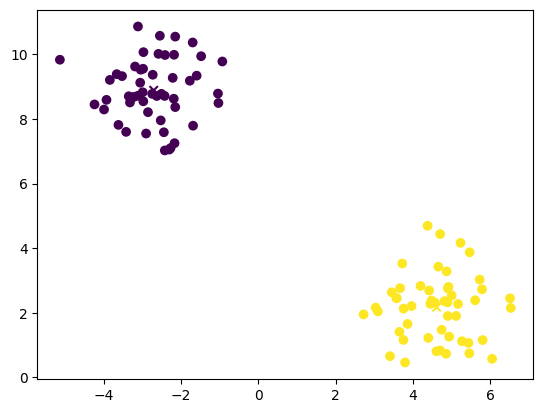

In [11]:
labels, centers = k_means(dataset, 2)

# Graph the dataset and the centers of gravity
plt.scatter([p.x for p in dataset], [p.y for p in dataset], c=labels)
plt.scatter([c.x for c in centers], [c.y for c in centers], c=[i for i in range(len(centers))], marker='x')

## Classification

The purpose of this pratical work is to handle the scikit-learn library and implement a classifier with a Cross validation stategy to optmize the hyperparameters. Take care of not including bias when you tune your (hyper) parameters.

### Load the data

sklearn comes with different datasets that can be used. In this excercise the idea
is to use a wine quality dataset.

In [12]:
from sklearn.datasets import load_wine
X,y = load_wine(return_X_y=True)

X.shape

(178, 13)

The dataset has 178 samples and 13 features for each sample.

### Run an SVM Classifier

In [13]:
from sklearn.svm import SVC

model = SVC()
model.fit(X, y)
pred = model.predict(X)

### Metrics

It is possible to get some metrics from the model we're trying to use.

In [14]:
from sklearn.metrics import accuracy_score

print("sklearn: ", accuracy_score(y, pred))

acc = np.mean(y == pred)
print("manual: ", acc)

sklearn:  0.7078651685393258
manual:  0.7078651685393258


### Unseen data

It is very important to measure performance using data different from the one used in
training. For that, the dataset should be splited in training and testing dataset.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)
X_train.shape, X_test.shape

((89, 13), (89, 13))

In [17]:
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
perf_test = accuracy_score(y_test, pred)
print(f"Performance on test set: {perf_test:.2f}")

Performance on test set: 0.65


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape

model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
perf_test = accuracy_score(y_test, pred)
print(f"Performance on test set: {perf_test:.2f}")

Performance on test set: 0.81


### Hyperparameter tuning

The previous example is a way to fit the model which is the process of fitting parameters
of the model. However, it is also important to fit hyperparameters of the model, in
this case, the C value.

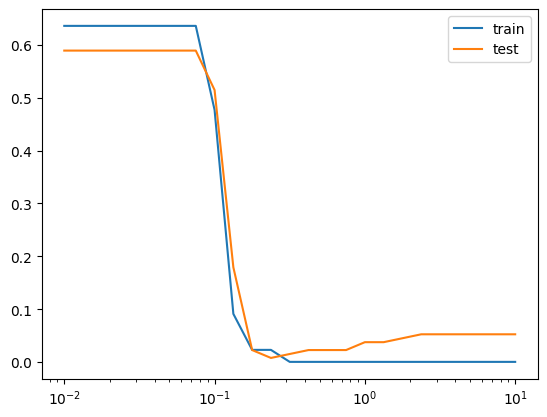

In [43]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=42)

scaler = StandardScaler()

x_train_norm = scaler.fit_transform(X_train)
x_test_norm = scaler.transform(X_test)

error_train = []
error_test = []

logscale = np.logspace(-2,1,25)

for C in logscale:
    model = SVC(C=C)
    model.fit(x_train_norm, y_train)
    pred_train = model.predict(x_train_norm)
    pred_test = model.predict(x_test_norm)
    perf_train = accuracy_score(y_train, pred_train)
    perf_test = accuracy_score(y_test, pred_test)
    error_train.append(1 - perf_train)
    error_test.append(1 - perf_test)


plt.plot(logscale, error_train, label="train")
plt.plot(logscale, error_test, label="test")
plt.xscale("log")
plt.legend()


To further illustrate how this works, the following bonuses show how can you also
fit the kernel and even the classification algorithm.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=42)

scaler = StandardScaler()

x_train_norm = scaler.fit_transform(X_train)
x_test_norm = scaler.transform(X_test)

error_train = []
error_test = []

c_scale = np.logspace(-2,1,25)
kernels = ["linear", "poly", "rbf", "sigmoid"]

for C in c_scale:
    c_errors_train = []
    c_errors_test = []
    for kernel in kernels:
        model = SVC(C=C)
        model.fit(x_train_norm, y_train)
        pred_train = model.predict(x_train_norm)
        pred_test = model.predict(x_test_norm)
        perf_train = accuracy_score(y_train, pred_train)
        perf_test = accuracy_score(y_test, pred_test)
        c_errors_train.append(1 - perf_train)
        c_errors_test.append(1 - perf_test)
    error_train.append(c_errors_train)
    error_test.append(c_errors_test)

min_error = 1
best_c = 0
best_kernel = ""
for c in range(len(c_scale)):
    for kernel in range(len(kernels)):
        if error_test[c][kernel] < min_error:
            min_error = error_test[c][kernel]
            best_c = c_scale[c]
            best_kernel = kernels[kernel]
        
print(f"Best C: {best_c:.2f}")
print(f"Best kernel: {best_kernel}")
print(f"Best error: {min_error:.2f}")


Best C: 0.24
Best kernel: linear
Best error: 0.01


That was my manual implementation, however scikit-learn comes with a solution for
testing a grid of parameters and identifying the best, look for GridSearchCV